In [1]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC Lasso' = '#c994c7', 'HSIC Lasso, B = 50' = '#df65b0',
             'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
             'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443')
methods <- c('HSIC Lasso', 'HSIC Lasso, B = 50',
             'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
             'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
             'HSIC Lasso, B = 5', 'mRMR', 'LARS')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('-B=', ', B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy, na.rm = T) / sqrt(ended), accuracy = mean(accuracy, na.rm = T) ) %>%
        ungroup %>%
        mutate(label = label)

}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
sc <- summarize_benchmark('../results/single_cell/normalized_expression_prediction.tsv')

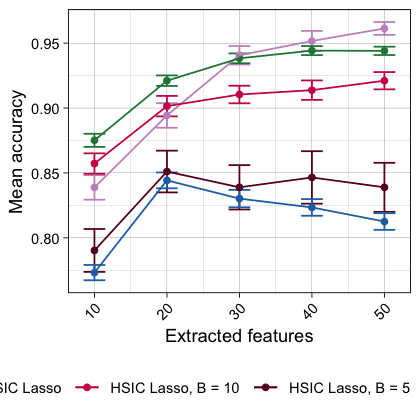

In [3]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
ggplot(sc, aes(x = selected, y = accuracy, color = model)) +
    geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
    geom_point() +
    geom_line() +
    theme_linedraw() +
    theme(legend.position = 'bottom',
          axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
    scale_color_manual(values = palette)

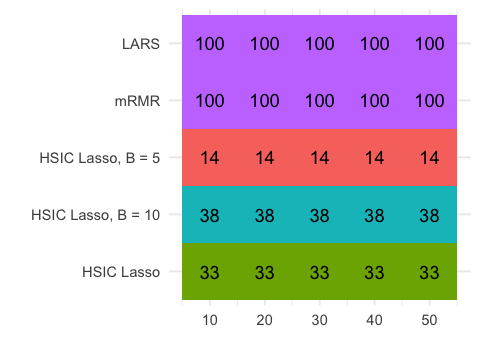

In [4]:
options(repr.plot.width=4, repr.plot.height=3)
ggplot(sc, aes(x = model, y = selected, fill = as.factor(ended), label = ended)) +
    geom_tile() +
    geom_text() +
    theme_minimal() +
    theme(legend.position = 'none') +
    labs(x = '', y = '') +
    coord_flip()